In [1]:
import torch
import torch.nn as nn

DEVICE = ('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
PAD_ID = 0
S_ID = 1
EOS_ID = 2
UNK_ID = 3

In [2]:
DEVICE

'cuda'

In [3]:
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

In [4]:
!pip install datasets

In [5]:
import datasets

train_data = datasets.load_dataset('wmt16','de-en',split='train[:50000]')
val_data = datasets.load_dataset('wmt16',"de-en", split="validation")
test_data = datasets.load_dataset('wmt16','de-en', split="test")

In [6]:
train_data.shape

(50000, 1)

In [7]:
val_data.shape

(2169, 1)

In [8]:
test_data.shape

(2999, 1)

In [9]:
from torch import Tensor
from torch.nn import Module,Dropout

class PositionalEncodings(Module):
    def __init__(self, d_model:int, max_len:int=512):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros((max_len, d_model))
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x:Tensor):
        return (self.pe[:x.size(1), :]).unsqueeze(0)

In [10]:
from torch.nn import Embedding

class TokenEmbedding(Module):
    def __init__(self, vocab_size:int, d_model:int):
        super().__init__()
        self.embed = Embedding(vocab_size, d_model)
        self.d_model = d_model
        self.vocab_size = vocab_size

    def forward(self, x:Tensor):
        return self.embed(x.long())

In [11]:
from torch.nn import Transformer,Linear,BatchNorm2d,Sequential
from typing import Any,List

class TransformerTranslation(Module):
    def __init__(self, src_vocab_size:int,
                 tgt_vocab_size:int,
                 emb_sizes:List[int],
                 d_model:int,
                 nhead:int,
                 num_encoder_layers:int,
                 num_decoder_layers:int,
                 dim_feedforward:int,
                 dropout:float=0.1,
                 activation:Any='relu'):
        super().__init__()

        self.transformer = Transformer(d_model=d_model,
                                        nhead=nhead,
                                        num_encoder_layers=num_encoder_layers,
                                        num_decoder_layers=num_decoder_layers,
                                        dim_feedforward=dim_feedforward,
                                        dropout=dropout,
                                        activation=activation,
                                        batch_first=True)
        self.generator = Sequential(
            nn.ReLU(inplace=True),
            Linear(d_model,tgt_vocab_size),
            nn.LogSoftmax(dim=-1))
        src_emb_size,tgt_emb_size = emb_sizes
        self.src_emb = TokenEmbedding(src_vocab_size,src_emb_size)
        self.tgt_emb = TokenEmbedding(tgt_vocab_size,tgt_emb_size)
        self.src_pos = PositionalEncodings(src_emb_size)
        self.tgt_pos = PositionalEncodings(tgt_emb_size)

    def forward(self,
                src:Tensor,
                tgt:Tensor,
                src_mask:Tensor=None,
                tgt_mask:Tensor=None,
                src_padding_mask:Tensor=None,
                tgt_padding_mask:Tensor=None,
                memory_key_padding_mask:Tensor=None):
        src_inp = self.src_emb(src) + self.src_pos(src)
        tgt_inp = self.tgt_emb(tgt) + self.tgt_pos(tgt)
        output = self.transformer(src=src_inp,
                                  tgt=tgt_inp,
                                  src_mask=src_mask,
                                  tgt_mask=tgt_mask,
                                  memory_mask=None,
                                  src_key_padding_mask=src_padding_mask,
                                  tgt_key_padding_mask=tgt_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask
                                )
        return self.generator(output)

    def encode(self, src:Tensor, src_mask:Tensor):
        return self.transformer.encoder(self.src_emb(src) + self.src_pos(src), src_mask)

    def decode(self, tgt:Tensor, memory:Tensor, tgt_mask:Tensor):
        return self.transformer.decoder(self.tgt_emb(tgt) + self.tgt_pos(tgt), memory, tgt_mask)

In [12]:
def generate_subsequent_mask(dim:int):
    mask = (torch.triu(torch.ones((dim,dim), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [13]:
def generate_mask(src:Tensor, tgt:Tensor):
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)
    tgt_mask = generate_subsequent_mask(tgt_seq_len)
    mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE)
    src_mask = mask.float().masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
    src_padding_mask = (src == PAD_ID)
    tgt_padding_mask = (tgt == PAD_ID)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [14]:
def compute_vocab(dataset,language):
    all_tokens = (' '.join(sample[language] for sample in dataset['translation'])).split()
    vocab = set(all_tokens)
    return all_tokens,vocab,len(vocab)

In [15]:
from tokenizers import Tokenizer,models
from tokenizers.trainers import BpeTrainer

src_tokens,src_vocab,src_vocab_size = compute_vocab(train_data,'de')
tgt_tokens,tgt_vocab,tgt_vocab_size = compute_vocab(train_data,'en')

tokenizer_de = Tokenizer(models.BPE())
tokenizer_en = Tokenizer(models.BPE())

special_tokens = ['<pad>', '<s>', '</s>', '<unk>']
trainer = BpeTrainer(special_tokens=special_tokens)

tokenizer_de.train_from_iterator(src_tokens,trainer=trainer)
tokenizer_en.train_from_iterator(tgt_tokens,trainer=trainer)

In [16]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss,MSELoss

d_model = 128
emb_sizes = [128,128]
nhead = 16
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 256
batch_size = 32
dropout = 0.2
activation = 'relu'
learning_rate = 0.0001
betas = (0.33, 0.81)
eps = 1e-9

translator = TransformerTranslation(src_vocab_size,
                                    tgt_vocab_size,
                                    emb_sizes,
                                    d_model,
                                    nhead,
                                    num_encoder_layers,
                                    num_decoder_layers,
                                    dim_feedforward,
                                    dropout,
                                    activation)
for p in translator.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

loss_fn = CrossEntropyLoss()
optimizer = optim.Adam(translator.parameters(),lr=learning_rate,betas=betas)

In [17]:
from torch.nn.utils.rnn import pad_sequence

def tensor_transform(tokenizer,text):
    token_ids = tokenizer.encode(text).ids
    return torch.cat([torch.tensor([S_ID]),torch.tensor(token_ids),torch.tensor([EOS_ID])])

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for sample in batch:
        src_batch.append(tensor_transform(tokenizer_de,sample['translation']['de']))
        tgt_batch.append(tensor_transform(tokenizer_en,sample['translation']['en']))
    src_batch = pad_sequence(src_batch, padding_value=PAD_ID, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_ID, batch_first=True)
    return src_batch, tgt_batch

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

def model_epoch(model, data_loader, loss_fn, optimizer, is_train:bool):
    model.to(DEVICE)
    model.train(is_train)
    total_loss = 0

    for src, tgt in data_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = generate_mask(src, tgt_input)
        with torch.set_grad_enabled(is_train):
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[:, 1:]
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            total_loss += loss.item()
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return total_loss / len(data_loader)

In [20]:
num_epochs = 30
train_losses, val_losses = [], []
min_val_loss = 1e10
bad_epochs = 0

for epoch in range(num_epochs):
    train_loss = model_epoch(translator, train_loader, loss_fn, optimizer, is_train=True)
    val_loss = model_epoch(translator, val_loader, loss_fn, optimizer, is_train=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (val_loss<min_val_loss):
        min_val_loss = val_loss
        bad_epochs = 0
    else:
        bad_epochs+=1

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss}')
    print(f'Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss}')
    print("----------------------------------------------")

    if(bad_epochs==num_epochs//7):
        print("Stopping early...")
        break

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/30 | Train Loss: 4.925829406053076
Epoch 1/30 | Val Loss: 3.6060747574357426
----------------------------------------------
Epoch 2/30 | Train Loss: 2.736067582000469
Epoch 2/30 | Val Loss: 3.492681250852697
----------------------------------------------
Epoch 3/30 | Train Loss: 2.6387825332920443
Epoch 3/30 | Val Loss: 3.467958267997293
----------------------------------------------
Epoch 4/30 | Train Loss: 2.596211281786801
Epoch 4/30 | Val Loss: 3.4565060191294728
----------------------------------------------
Epoch 5/30 | Train Loss: 2.55961512215078
Epoch 5/30 | Val Loss: 3.4283319536377403
----------------------------------------------
Epoch 6/30 | Train Loss: 2.52218855029867
Epoch 6/30 | Val Loss: 3.4039947232779335
----------------------------------------------
Epoch 7/30 | Train Loss: 2.502463856913383
Epoch 7/30 | Val Loss: 3.4075324430185208
----------------------------------------------
Epoch 8/30 | Train Loss: 2.4728439494881655
Epoch 8/30 | Val Loss: 3.3941132847

KeyboardInterrupt: 

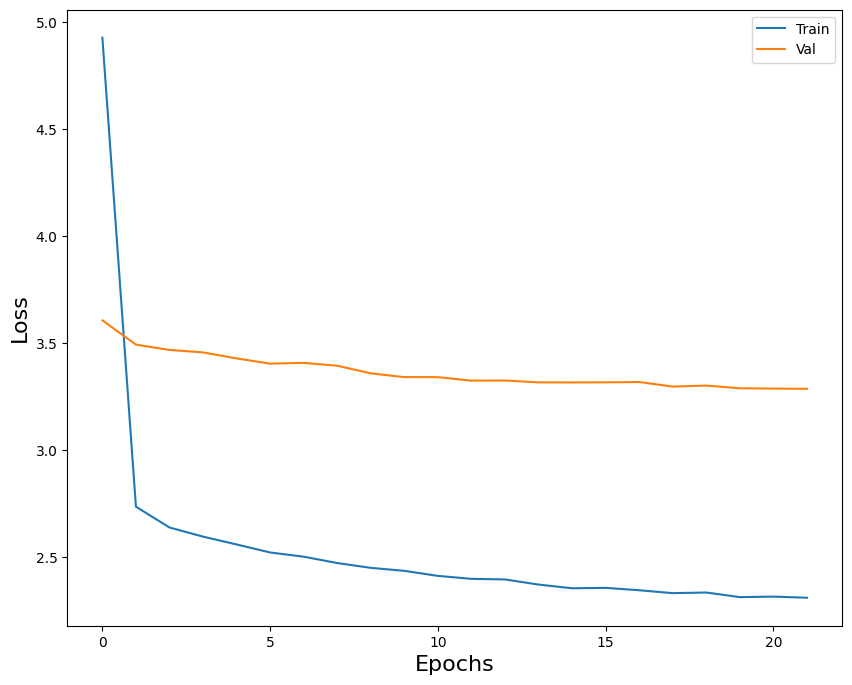

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(train_losses, label="Train")
if(len(val_losses)>0):
    plt.plot(val_losses, label="Val")

plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

In [22]:
def greedy_decode(model,src,src_mask,max_len=512,start_symbol=S_ID):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    memory = model.encode(src, src_mask)
    memory = memory.to(DEVICE)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = (generate_subsequent_mask(ys.size(1))).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_ID:
            break
    return ys

In [26]:
def translate_2A(model:Module,tokenizer_de,tokenizer_en,src_sentence:str):
    model.eval()
    model.to(DEVICE)
    src = (tensor_transform(tokenizer_de,src_sentence)).view(1,-1)
    num_tokens = src.size(1)
    src_mask = (torch.zeros(num_tokens,num_tokens))
    tgt = greedy_decode(model,src,src_mask,num_tokens+5,S_ID).flatten()
    return tokenizer_en.decode(tgt.cpu().numpy(),skip_special_tokens=True)

In [27]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
import evaluate

candidates = []
references = []

for sample in test_data['translation']:
    src,tgt = sample['de'],sample['en']
    translation = translate_2A(translator,tokenizer_de,tokenizer_en,src)
    candidates.append(translation)
    references.append(tgt)

In [29]:
bleu_metric = evaluate.load('bleu')

bleu = bleu_metric.compute(predictions=candidates,references=references)
print(f"BLEU-1: {bleu['precisions'][0]}")
print(f"BLEU-2: {bleu['precisions'][1]}")
print(f"BLEU-3: {bleu['precisions'][2]}")
print(f"BLEU-4: {bleu['precisions'][3]}")

BLEU-1: 0.010352979538599495
BLEU-2: 0.00024175662465707347
BLEU-3: 0.0
BLEU-4: 0.0


In [ ]:
from datasets import load_metric

meteor_metric = load_metric('meteor')

meteor = meteor_metric.compute(predictions=candidates,references=references)
print(f"Meteor Score: {meteor['meteor']}")

In [53]:
bertscore_metric = evaluate.load('bertscore')

bertscore = bertscore_metric.compute(predictions=candidates, references=references, model_type="distilbert-base-uncased")
print(f"BERTScore: {sum(bertscore['precision'])/len(bertscore['precision'])}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

BERTScore: 0.5442488059356794
